# Exploratory Data Analysis on r/AITA
I will be exploring this subreddit as well as what makes a "good" post on it. 


Going into this my main thoughts are that 

### Setup

In [17]:
import sys
import importlib
import graphviz
from IPython.display import Image
import pandas as pd
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

In [2]:
sys.path.append("..")

load_dotenv(dotenv_path=Path("../settings.env"))

True

In [3]:
client = bigquery.Client()

In [4]:
# Remote data definitions
PROJ_NAME = "bonion"
DATASET_NAME = "AITA_dataset"
post_table_id = "{}.{}.post_table".format(PROJ_NAME, DATASET_NAME)
comment_table_id = "{}.{}.comment_table".format(PROJ_NAME, DATASET_NAME)
reply_table_id = "{}.{}.reply_table".format(PROJ_NAME, DATASET_NAME)

# Ideas
1. Most common words
1. Most common classifications 
1. What kind of posts get which kind of classifications 

## A Look At the Data

In [10]:
from data import data_utils
importlib.reload(data_utils)

<module 'data.data_utils' from '/home/cstainsby/class/dataProj/bonion/src/notebooks/../data/data_utils.py'>

In [5]:
# get data from GCP
query_for_post_data = """
    SELECT reddit_post_id AS post_id, post_title, post_self_text AS post_content, posts.upvotes AS post_upvotes, 
            comment_id, content AS comment_content, comments.upvotes AS comment_upvotes
    FROM {} posts JOIN {} comments ON (posts.reddit_post_id = SUBSTRING(comments.parent_id, 4, 100));
""".format(post_table_id, comment_table_id)

post_join_comment_df = pd.read_gbq(query_for_post_data, project_id=PROJ_NAME)

post_join_comment_df.head(4)

,post_id,post_title,post_content,post_upvotes,comment_id,comment_content,comment_upvotes
0,jyk2ac,AITA for leaving the call when my brother anno...,My brother and I do not get on.\n\nWhen we wer...,22802,gd4fbhf,Nta. Your kid is gonna grow up with half sibli...,11786
1,jyk2ac,AITA for leaving the call when my brother anno...,My brother and I do not get on.\n\nWhen we wer...,22802,gd4e5me,NTA- id have cut em both out completely. They’...,4036
2,jyk2ac,AITA for leaving the call when my brother anno...,My brother and I do not get on.\n\nWhen we wer...,22802,gd4e513,NTA\n\nI think you handled the situation as we...,26273
3,jyk2ac,AITA for leaving the call when my brother anno...,My brother and I do not get on.\n\nWhen we wer...,22802,gd4eips,"This is a lot to unpack, but you're definitely...",2271


### Number of Rows for each Table

In [9]:
print(pd.read_gbq("SELECT COUNT(*) AS {} FROM {}".format("rows_in_posts", post_table_id), project_id=PROJ_NAME))
print(pd.read_gbq("SELECT COUNT(*) AS {} FROM {}".format("rows_in_comments", comment_table_id), project_id=PROJ_NAME))
print(pd.read_gbq("SELECT COUNT(*) AS {} FROM {}".format("rows_in_replies", reply_table_id), project_id=PROJ_NAME))

   rows_in_posts
0            998
   rows_in_comments
0              2796
   rows_in_replies
0             9518


### How Many of Each Class
I'm going to build a dictionary for { post_class &rarr; (comment_class, num_comment_class_occurances) } and another dictionary for { post_class &rarr; num__post_class_occurances }

### Graph Showing Distribution of Classes

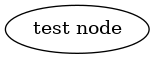

In [18]:
classification_graph = graphviz.Digraph("Classification Graph", comment="Shows which comment classifications go to which comment classifications based on user voting")
classification_graph.node("A", "test node")
classification_graph.render(directory="static", format='png')
display(Image(filename='static/Classification Graph.gv.png'))

## Sentiment Analysis and Classification
In the AITA subreddit, how it works is someone posts about something which has happened or might happen in the future. It is then the job of the commenters to tell the original poster what they think of their situation using these possible classifications.
- YTA = You're the Asshole
- YWBTA = You Would Be the Asshole
- NTA = Not the Asshole
- YWNBTA = You Would Not be the Asshole
- ESH = Everyone Sucks here
- NAH = No Assholes here
- INFO = Not Enough Info

So it is then our job as the data scientist to find out, based on the post contents and title, what the classification will be.